In [49]:
import os
import numpy as np
import pandas as pd
from collections import deque

!pip install music21
!pip install pygame

from music21 import converter, instrument, note, chord, bar, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [50]:
# grab / parse data

In [149]:
midi_directory = "midi/Piano_small"
# specify the number of track in each song (should be the same, in same order, for each song)
tracks = (0,)
instru = instrument.Piano()

notes = [[] for track in tracks]
durations = [[] for track in tracks]
offsets = [[] for track in tracks]
velocities = [[] for track in tracks]
for i, file in enumerate(os.listdir(midi_directory)):
    midi_part = converter.parse(os.path.join(midi_directory, file))
    # Parse the midi file by the notes/chords it contains
    for track, _ in enumerate(tracks):
        notes_to_parse = midi_part[tracks[track]].flat.notesAndRests
        last_offset = 0
        for elem in notes_to_parse:
            if isinstance(elem, note.Note):
                notes[track].append([str(elem.pitch)])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(elem.volume.velocity)
            elif isinstance(elem, chord.Chord):
                notes[track].append([str(n.nameWithOctave) for n in elem.pitches])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(elem.volume.velocity)
            elif isinstance(elem, note.Rest):
                notes[track].append([elem.name])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(0)
            last_offset = elem.offset
    print("Song %s Loaded" % file)
print("DONE LOADING SONGS") 
# Get all notes
np_notes = [np.array(notes[track]) for track, _ in enumerate(tracks)]
#np_notes = [np_notes[track].flatten() for track in tracks]
notes_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for item in np_notes[track]:
        if len(item) > 1 and item != "rest":
            notes_vocab[track].append(",".join([note for note in item]))
        else:
            notes_vocab[track].append(item[0])
    notes_vocab[track] = sorted(set(notes_vocab[track]))
# Get all durations
durations_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    durations_vocab[track] = sorted(set(durations[track]))
# Get all offsets
offsets_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    offsets_vocab[track] = sorted(set(offsets[track]))
# Get all velocities
velocities_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    velocities_vocab[track] = sorted(set(velocities[track]))
    
for track, _ in enumerate(tracks):
    print("%s Notes, notes_Vocab : %s ; durations_Vocab : %s ; offsets_vocab : %s ; velocities_vocab : %s" % 
          (len(notes[track]), len(notes_vocab[track]), len(durations_vocab[track]), len(offsets_vocab[track]), len(velocities_vocab[track])))
print(notes_vocab, notes)
print(durations_vocab, durations)
print(offsets_vocab, offsets)
print(velocities_vocab, velocities)

Song alb_esp3_format0.mid Loaded
Song bach_850_format0.mid Loaded
Song bk_xmas4_format0.mid Loaded
Song brahms_opus1_2_format0.mid Loaded
Song chp_op31_format0.mid Loaded
Song god_alb_esp2_format0.mid Loaded
Song grieg_halling_format0.mid Loaded
Song haydn_35_3_format0.mid Loaded
Song mendel_op53_5_format0.mid Loaded
Song muss_4_format0.mid Loaded
Song pathetique_2_format0.mid Loaded
Song schumm-3_format0.mid Loaded
Song schu_143_2_format0.mid Loaded
Song scn68_12_format0.mid Loaded
Song ty_februar_format0.mid Loaded
Song waldstein_3_format0.mid Loaded
DONE LOADING SONGS
20063 Notes, notes_Vocab : 2279 ; durations_Vocab : 111 ; offsets_vocab : 62 ; velocities_vocab : 100
[['A1', 'A1,A2', 'A1,C#2,A2', 'A1,D2,A2', 'A2', 'A2,A1', 'A2,A3', 'A2,B2,E-3,F#3', 'A2,D2', 'A2,D3', 'A2,D3,A3', 'A2,E3', 'A2,E3,D2', 'A2,E3,G3', 'A2,F3', 'A2,F3,F2', 'A3', 'A3,A1', 'A3,A2', 'A3,A2,C#3', 'A3,A2,F3', 'A3,A4', 'A3,A4,A1,A2', 'A3,A4,A2', 'A3,A4,F4,F3,C3,F2', 'A3,A5', 'A3,B3', 'A3,B3,B2', 'A3,B3,C#3', 'A3,

In [111]:
# Save vocab to file

In [112]:
np.save("vocab.npy", np.array([notes_vocab, durations_vocab, offsets_vocab, velocities_vocab]))

In [113]:
# turn notes to integers:

In [150]:
cat_notes = [[] for track in tracks]
cat_durations = [[] for track in tracks]
cat_offsets = [[] for track in tracks]
cat_velocities = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in notes[track]:
        int_note = notes_vocab[track].index(",".join(elem))
        cat = np.zeros((len(notes_vocab[track])))
        cat[int_note] = 1
        cat_notes[track].append(cat)
    for elem in durations[track]:
        int_duration = durations_vocab[track].index(elem)
        cat = np.zeros((len(durations_vocab[track])))
        cat[int_duration] = 1
        cat_durations[track].append(cat)
    for elem in offsets[track]:
        int_offset = offsets_vocab[track].index(elem)
        cat = np.zeros((len(offsets_vocab[track])))
        cat[int_offset] = 1
        cat_offsets[track].append(cat)
    for elem in velocities[track]:
        int_velocity = velocities_vocab[track].index(elem)
        cat = np.zeros((len(velocities_vocab[track])))
        cat[int_velocity] = 1
        cat_velocities[track].append(cat)
# merge
x = [cat_notes, cat_durations, cat_offsets, cat_velocities]

In [151]:
print([len(x[0][i]) for i, _ in enumerate(tracks)])

[20063]


In [152]:
# Build generator

In [153]:
seq_len = 32
batch_size = 32
#split = int(0.8 * len(x))

class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
        
    def __len__(self):
        return min([len(self.x[0][i]) for i, _ in enumerate(tracks)]) // self.batch_size - 1
    
    def __getitem__(self, idx):
        X_note = [[] for track in tracks]
        X_duration = [[] for track in tracks]
        X_offset = [[] for track in tracks]
        X_velocity = [[] for track in tracks]
        
        Y_note = [[] for track in tracks]
        Y_duration = [[] for track in tracks]
        Y_offset = [[] for track in tracks]
        Y_velocity = [[] for track in tracks]
        
        res = [[], []]
        for track, _ in enumerate(tracks):
            for i in range(self.batch_size):
                
                X_note[track].append(self.x[0][track][idx+i : idx+i + seq_len])
                X_duration[track].append(self.x[1][track][idx+i : idx+i + seq_len])
                X_offset[track].append(self.x[2][track][idx+i : idx+i + seq_len])
                X_velocity[track].append(self.x[3][track][idx+i : idx+i + seq_len])
                
                Y_note[track].append(self.x[0][track][idx+i + seq_len])
                Y_duration[track].append(self.x[1][track][idx+i + seq_len])
                Y_offset[track].append(self.x[2][track][idx+i + seq_len])
                Y_velocity[track].append(self.x[3][track][idx+i + seq_len])
            
            X_note[track] = np.array(X_note[track])
            X_duration[track] = np.array(X_duration[track])
            X_offset[track] = np.array(X_offset[track])
            X_velocity[track] = np.array(X_velocity[track])
            
            Y_note[track] = np.array(Y_note[track])
            Y_duration[track] = np.array(Y_duration[track])
            Y_offset[track] = np.array(Y_offset[track])
            Y_velocity[track] = np.array(Y_velocity[track])
            
            res[0].append(X_note[track])
            res[0].append(X_duration[track])
            res[0].append(X_offset[track])
            res[0].append(X_velocity[track])
            
            res[1].append(Y_note[track])
            res[1].append(Y_duration[track])
            res[1].append(Y_offset[track])
            res[1].append(Y_velocity[track])
            
        return res
data_gen = dataGenerator(x, batch_size)

In [154]:
data_gen[0][0][0].shape

(32, 32, 2279)

In [155]:
# Build Model

In [156]:
K.clear_session()

inputs_list = []
tracks_list = []
outputs_list = []

for track, _ in enumerate(tracks):
    in_note = Input(shape=(seq_len, len(notes_vocab[track])))
    inputs_list.append(in_note)
    x1 = LSTM(64, return_sequences=True)(in_note)
    x1 = Bidirectional(LSTM(32))(x1)
    x1 = Dropout(0.3)(x1)
    tracks_list.append(x1)
    
    in_duration = Input(shape=(seq_len, len(durations_vocab[track])))
    inputs_list.append(in_duration)
    x2 = LSTM(64, return_sequences=True)(in_duration)
    x2 = Bidirectional(LSTM(32))(x2)
    x2 = Dropout(0.3)(x2)
    tracks_list.append(x2)

    in_offset = Input(shape=(seq_len, len(offsets_vocab[track])))
    inputs_list.append(in_offset)
    x3 = LSTM(64, return_sequences=True)(in_offset)
    x3 = Bidirectional(LSTM(32))(x3)
    x3 = Dropout(0.3)(x3)
    tracks_list.append(x3)
    
    in_velocity = Input(shape=(seq_len, len(velocities_vocab[track])))
    inputs_list.append(in_velocity)
    x4 = LSTM(64, return_sequences=True)(in_velocity)
    x4 = Bidirectional(LSTM(32))(x4)
    x4 = Dropout(0.3)(x4)
    tracks_list.append(x4)

concat = Concatenate()(tracks_list)
shared = Dense(64, activation='relu')(concat)
shared = Dense(32, activation='relu')(shared)

for track, _ in enumerate(tracks):
    out_note = Dense(len(notes_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_note)
    
    out_duration = Dense(len(durations_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_duration)
    
    out_offset = Dense(len(offsets_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_offset)
    
    out_velocity = Dense(len(velocities_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_velocity)

model = Model(inputs=inputs_list, 
              outputs=outputs_list)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 2279)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 111)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 32, 62)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 32, 100)      0                                            
__________________________________________________________________________________________________
lstm_1 (LS

In [157]:
#save best model if model improved
model_name = "Piano.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join("weight_save", model_name), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [122]:
h = model.fit_generator(data_gen, epochs = 15, callbacks=[best_checkpoint])

Epoch 1/15
22/22 [==============================] - 30s 1s/step - loss: 28.9744 - dense_3_loss: 4.3141 - dense_4_loss: 2.3528 - dense_5_loss: 1.6996 - dense_6_loss: 1.0193 - dense_7_loss: 4.6740 - dense_8_loss: 2.3942 - dense_9_loss: 2.6711 - dense_10_loss: 1.1505 - dense_11_loss: 3.4512 - dense_12_loss: 1.8437 - dense_13_loss: 1.6841 - dense_14_loss: 1.7200 - dense_3_acc: 0.0028 - dense_4_acc: 0.0028 - dense_5_acc: 0.6634 - dense_6_acc: 0.4062 - dense_7_acc: 0.0043 - dense_8_acc: 0.4148 - dense_9_acc: 0.0000e+00 - dense_10_acc: 0.5327 - dense_11_acc: 0.0312 - dense_12_acc: 0.4318 - dense_13_acc: 0.7244 - dense_14_acc: 0.7131  
Epoch 2/15


c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


22/22 [==============================] - 6s 259ms/step - loss: 18.9018 - dense_3_loss: 3.4503 - dense_4_loss: 1.4063 - dense_5_loss: 0.9200 - dense_6_loss: 0.2131 - dense_7_loss: 3.8754 - dense_8_loss: 1.8034 - dense_9_loss: 1.8167 - dense_10_loss: 0.1649 - dense_11_loss: 2.6132 - dense_12_loss: 1.3548 - dense_13_loss: 0.9333 - dense_14_loss: 0.3505 - dense_3_acc: 0.1122 - dense_4_acc: 0.4901 - dense_5_acc: 0.8111 - dense_6_acc: 1.0000 - dense_7_acc: 0.0526 - dense_8_acc: 0.5057 - dense_9_acc: 0.4702 - dense_10_acc: 1.0000 - dense_11_acc: 0.2301 - dense_12_acc: 0.8210 - dense_13_acc: 0.7969 - dense_14_acc: 0.9915
Epoch 3/15
22/22 [==============================] - 6s 273ms/step - loss: 14.0403 - dense_3_loss: 2.8639 - dense_4_loss: 0.8975 - dense_5_loss: 0.8074 - dense_6_loss: 0.0554 - dense_7_loss: 3.1250 - dense_8_loss: 1.4327 - dense_9_loss: 1.1668 - dense_10_loss: 0.0329 - dense_11_loss: 1.7713 - dense_12_loss: 1.0996 - dense_13_loss: 0.7197 - dense_14_loss: 0.0682 - dense_3_acc: 0

22/22 [==============================] - 8s 356ms/step - loss: 2.0848 - dense_3_loss: 0.5240 - dense_4_loss: 0.1287 - dense_5_loss: 0.1558 - dense_6_loss: 3.8685e-04 - dense_7_loss: 0.5847 - dense_8_loss: 0.1995 - dense_9_loss: 0.1241 - dense_10_loss: 1.3311e-04 - dense_11_loss: 0.2949 - dense_12_loss: 0.0310 - dense_13_loss: 0.0322 - dense_14_loss: 0.0095 - dense_3_acc: 0.8707 - dense_4_acc: 0.9545 - dense_5_acc: 0.9616 - dense_6_acc: 1.0000 - dense_7_acc: 0.8338 - dense_8_acc: 0.9190 - dense_9_acc: 0.9602 - dense_10_acc: 1.0000 - dense_11_acc: 0.8963 - dense_12_acc: 0.9957 - dense_13_acc: 0.9943 - dense_14_acc: 0.9972
Epoch 15/15
22/22 [==============================] - 8s 357ms/step - loss: 1.6293 - dense_3_loss: 0.4414 - dense_4_loss: 0.0870 - dense_5_loss: 0.1403 - dense_6_loss: 1.3694e-04 - dense_7_loss: 0.4239 - dense_8_loss: 0.1363 - dense_9_loss: 0.1018 - dense_10_loss: 3.4837e-05 - dense_11_loss: 0.2290 - dense_12_loss: 0.0380 - dense_13_loss: 0.0257 - dense_14_loss: 0.0058 -

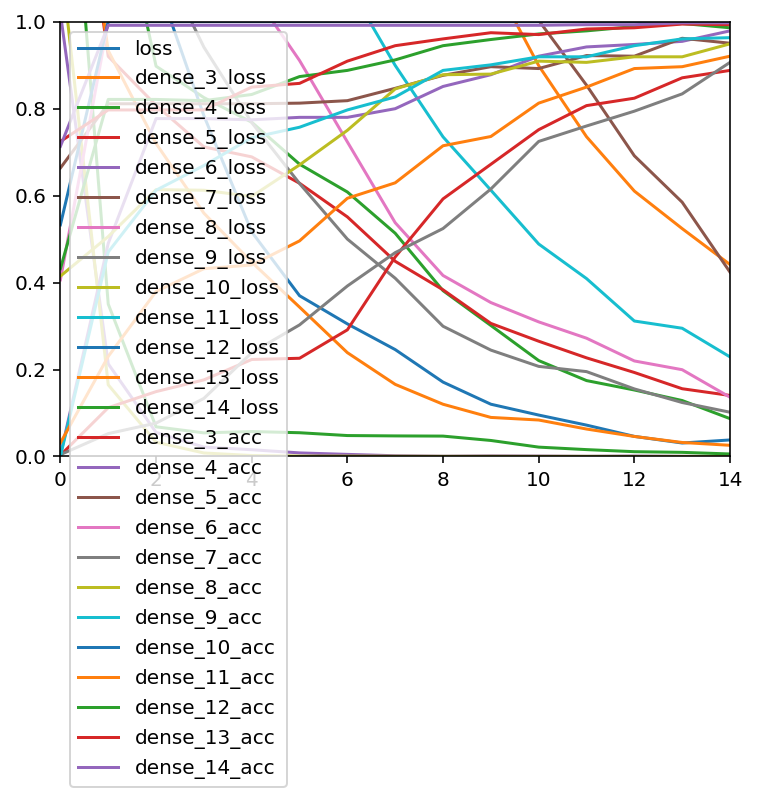

In [123]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [124]:
# Load / save

In [158]:
#model.save(os.path.join("weight_save", model_name))
model = load_model(os.path.join("weight_save", model_name))

In [159]:
# Test

In [224]:
# Build seed
idx = 87
x_test, _ = data_gen[idx]
x_test = [x_test[i][0] for i in range(len(x_test))]
x_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(x_test[0])):
        str_note = notes_vocab[track][np.argmax(x_test[4*track][i])]
        _duration = durations_vocab[track][np.argmax(x_test[4*track+1][i])]
        _offset = offsets_vocab[track][np.argmax(x_test[4*track+2][i])]
        _velocity = velocities_vocab[track][np.argmax(x_test[4*track+3][i])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = _duration
            _chord.offset = _offset
            _chord.volume.velocity = _velocity
            x_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = _duration
                _note.offset = _offset
                _note.volume.velocity = _velocity
                x_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = _duration
                _rest.offset = _offset
                x_test_stream[track].append(_rest)
    x_test_stream[track].insert(0, instru)

In [225]:
# make seq_len predictions from seed
preds = [[] for track in tracks]
x = x_test

for _ in range(seq_len*8):
    pred = model.predict([np.array([x[i]]) for i in range(len(x))])
    _note = [pred[i] for i in range(0, len(pred), 4)]
    _duration = [pred[i] for i in range(1, len(pred), 4)]
    _offset = [pred[i] for i in range(2, len(pred), 4)]
    _velocity = [pred[i] for i in range(3, len(pred), 4)]
    for track, _ in enumerate(tracks):
        cat_note = np.zeros((len(notes_vocab[track])))
        _note[track] = np.argmax(_note[track])
        cat_note[_note[track]] = 1
        cat_duration = np.zeros((len(durations_vocab[track])))
        _duration[track] = np.argmax(_duration[track])
        cat_duration[_duration[track]] = 1
        cat_offset = np.zeros((len(offsets_vocab[track])))
        _offset[track] = np.argmax(_offset[track])
        cat_offset[_offset[track]] = 1
        cat_velocity = np.zeros((len(velocities_vocab[track])))
        _velocity[track] = np.argmax(_velocity[track])
        cat_velocity[_velocity[track]] = 1
        
        x[4*track] = x[4*track][1:]
        x[4*track] = list(x[4*track]) + [cat_note]
        
        x[4*track+1] = x[4*track+1][1:]
        x[4*track+1] = list(x[4*track+1]) + [cat_duration]
        
        x[4*track+2] = x[4*track+2][1:]
        x[4*track+2] = list(x[4*track+2]) + [cat_offset]
        
        x[4*track+3] = x[4*track+3][1:]
        x[4*track+3] = list(x[4*track+3]) + [cat_velocity]
        
        preds[track].append((cat_note, cat_duration, cat_offset, cat_velocity))

In [220]:
# Build predicted stream
y_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(preds[track])):
        str_note = notes_vocab[track][np.argmax(preds[track][i][0])]
        _duration = durations_vocab[track][np.argmax(preds[track][i][1])]
        _offset = offsets_vocab[track][np.argmax(preds[track][i][2])]
        _velocity = velocities_vocab[track][np.argmax(preds[track][i][3])]
        
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = _duration
            _chord.offset = _offset
            _chord.volume.velocity = _velocity
            y_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = _duration
                _note.offset = _offset
                _note.volume.velocity = _velocity
                y_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = _duration
                _rest.offset = _offset
                y_test_stream[track].append(_rest)
    y_test_stream[track].insert(0, instru)

In [222]:
# play seed
x_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(x_test_stream[track])
    x_full_score.insert(0, p)
x_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_full_score)
sp.play()

In [223]:
# play generated music
y_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(y_test_stream[track])
    y_full_score.insert(0, p)
y_full_score.write("midi", "y_test.mid")
sp = midi.realtime.StreamPlayer(y_full_score)
sp.play()